In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

편지지만 잘라내기

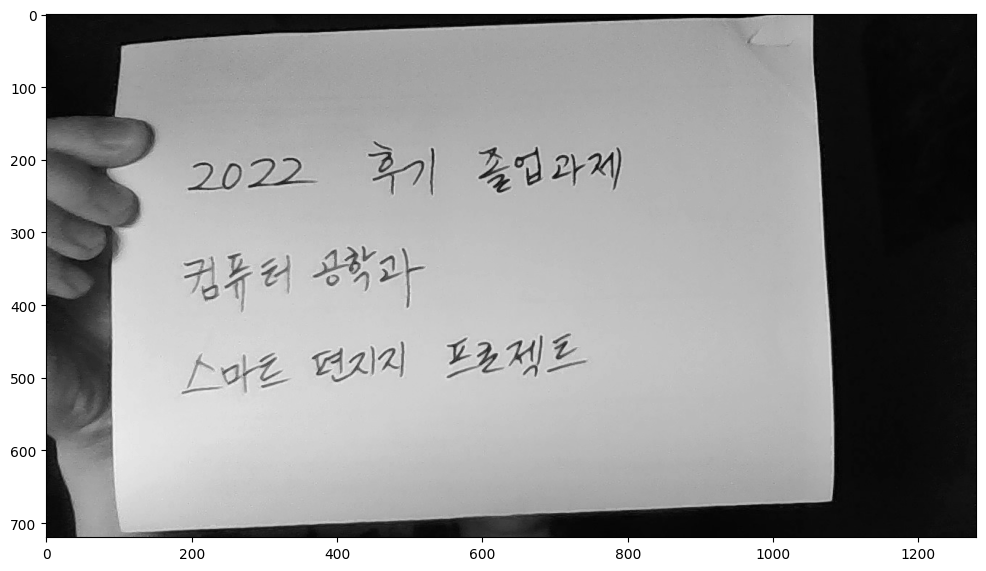

In [30]:
#흑백으로 변환
img_ori=cv2.imread("photo.jpg")
height, width, channel = img_ori.shape
img_gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12, 10))
plt.imshow(img_gray,cmap='gray')
#plt.show()

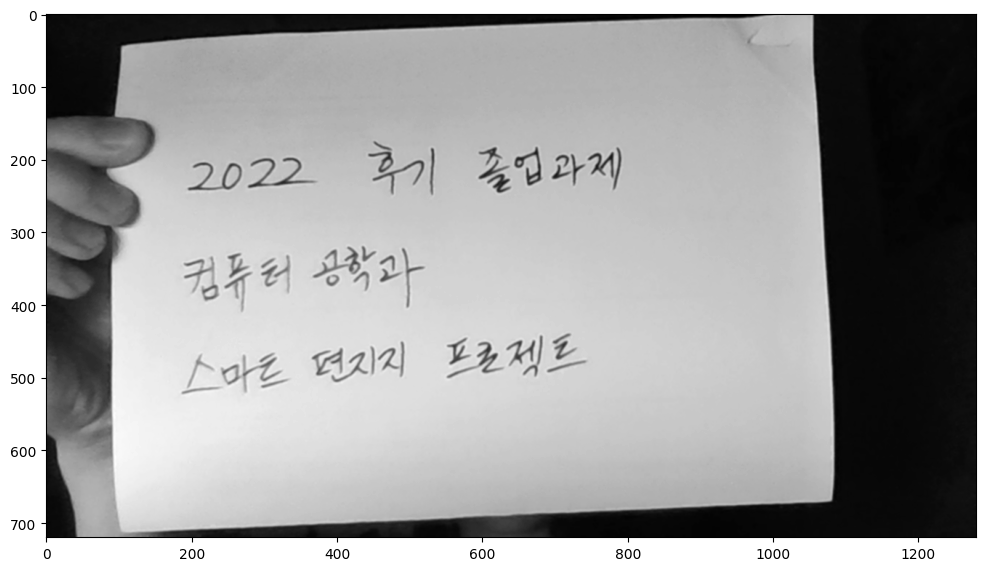

In [31]:
#가우시안 블러링
img_blurred = cv2.GaussianBlur(img_gray, ksize=(5, 5), sigmaX=0) # 5 * 5 크기의 가우시안 마스크를 영상에 적용.

plt.figure(figsize=(12, 10))
plt.imshow(img_blurred, cmap='gray')

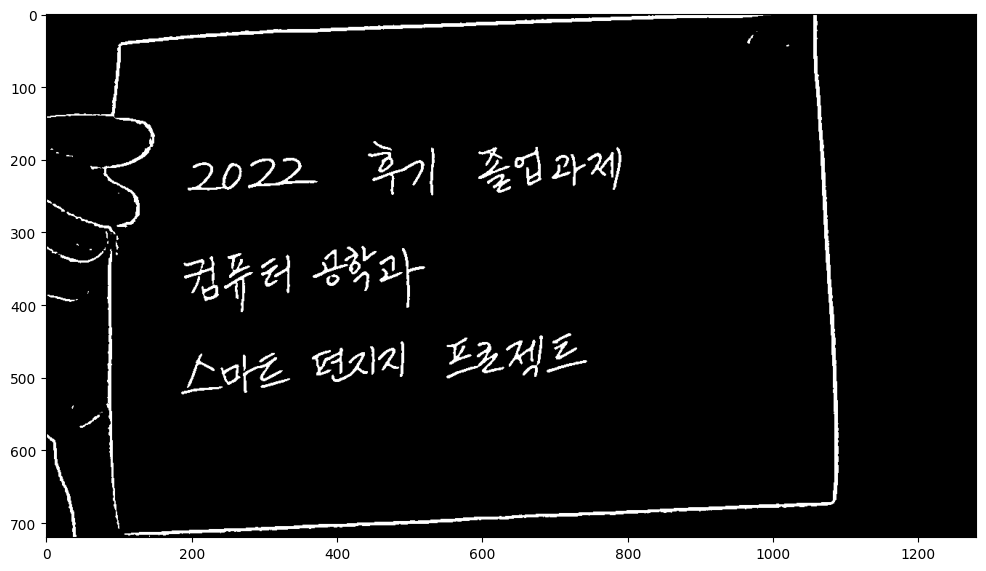

In [32]:
#이진화(adaptive threshold기법)
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)
# img, 최대값
'''
adaptive method = T값의 결정 방법. (T를 기준으로 영상의 픽셀값이 255 또는 0으로 이진화 된다.)
cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 가우시안 커널을 만들어서 적용한 후(커널사이즈는 Blocksize^2) 그 결과값을 T로 책정
cv2.ADAPTIVE_THRESH_MEAN_C : blocksize^2만큼의 영역을 만들어서 그 값들의 평균을 T로 책정(메디안 필터)

thresholdType = 픽셀 값 결정 방법.
cv2.THRESH_BINARY_INV : 픽셀값이 T보다 작을경우 값은 255
cv2.THRESH_BINARY : 픽셀값 T보다 클경우 값은 255

blockSize : 커널의 사이즈. adaptive method와 연관있음.
C : adaptive method와 연관있는 값으로 T 연산결과에서 빼주는 상수값임.
'''

# 19x19만큼의 영역 내에서 T를 계산하여 각 픽셀값을 이진화 시킨다.

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

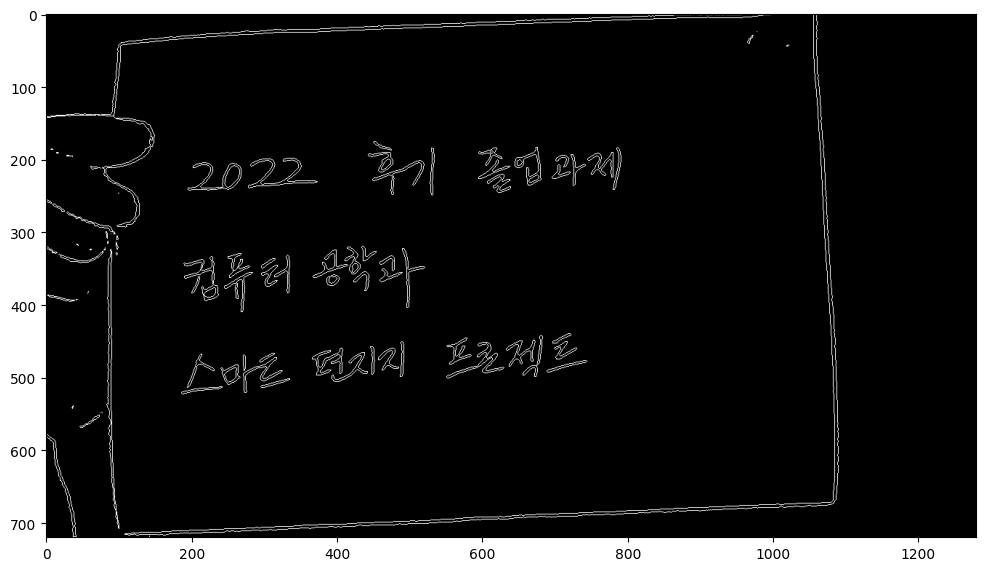

In [33]:
#윤곽 찾기
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
) # (image, mode, method) # 윤곽선 찾는 함수
'''
Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following. CVGIP 30 1, pp 32-46 (1985)
위의 논문 내용을 토대로 윤곽선을 찾아냄
https://www.academia.edu/15495158/Topological_Structural_Analysis_of_Digitized_Binary_Images_by_Border_Following

mode : 뽑아낼 윤곽선의 위치
CV_RETR_EXTERNAL : 가장 외곽에 위치한 윤곽선만 추출 (계층 구조 없음)
CV_RETR_LIST : 모든 윤곽선을 추출 (계층 구조 없음)
CV_RETR_CCOMP : 모든 윤곽선 추출 (계층구조 2단계)
CV_RETR_TREE : 모든 윤곽선 추출 (트리형식의 모든 계층구조)

method : 윤곽선 근사화 방법
CV_CHAIN_APPROX_NONE : 모든 윤곽선과 그 윤곽선의 정확한 위치를 기록하여 저장
CV_CHAIN_APPROX_SIMPLE : 윤곽선의 수직 수평 대각선을 압축하여 끝점만을 기록하여 저장
CV_CHAIN_APPROX_TC89_L1,CV_CHAIN_APPROX_TC89_KCOS : Teh-Chin chain approximation algorithm의 방법을 사용
Teh, C.H. and Chin, R.T., On the Detection of Dominant Points on Digital Curve. PAMI 11 8, pp 859-872 (1989)
https://076923.github.io/posts/Python-opencv-21/ <-참조
'''
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255)) # 윤곽선을 그린다.
'''
img, 윤곽선 벡터, 그릴윤곽선의 인덱스(음수일경우 모두 그림), 윤곽선의 색
'''

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

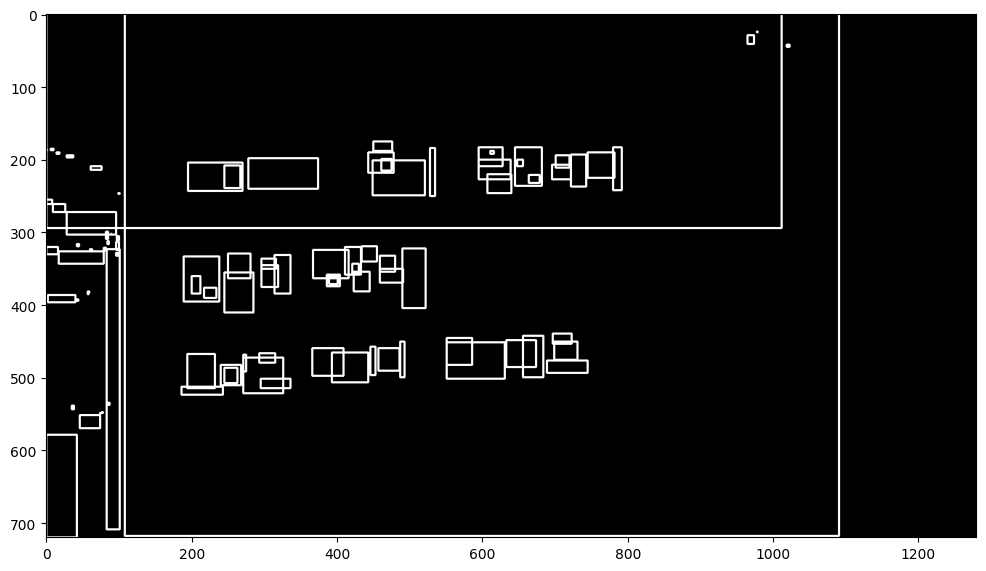

In [34]:
#윤곽을 토대로 사각형 그리기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = [] # 각 윤곽선에서 사각형 영역과 중심좌표를 알아내어 저장할 리스트

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) # 끝점에서 사각형 영역을 뽑아낸다
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2) # 윤곽선을 사각형으로 그려서 표현
    
    # insert to dict
    contours_dict.append({
        'contour': contour, # 실제 윤곽선
        'x': x,             # 윤곽선의 왼쪽 상단 x좌표
        'y': y,             # 윤곽선의 왼쪽 상단 y좌표
        'w': w,             # 윤곽선의 너비
        'h': h,             # 윤곽선의 높이
        'cx': x + (w / 2),  # 윤곽선의 중심 x좌표
        'cy': y + (h / 2)   # 윤곽선의 중심 y좌표
    }) # 리스트에 추가

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray') # 뽑아낸 영역들 출력.

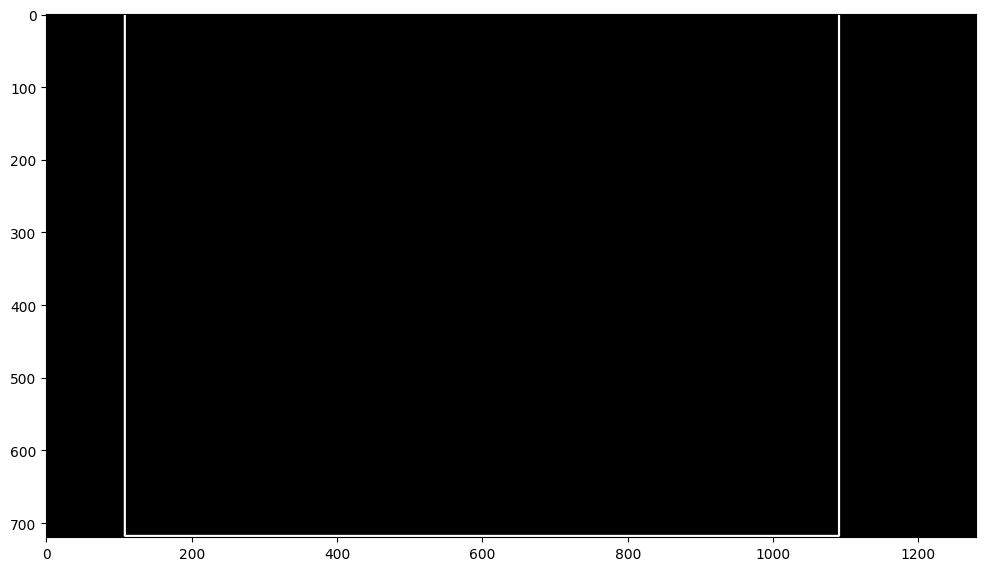

In [35]:
#contours_dict 안에서 가장 넓은 높이와 너비를 가진 사각형 추출

#가장 큰 사각형이 너무 작을 경우(이건 실험적으로 설정) 다시 찍도록 함
#네 모서리가 모두 화면에 들어오고 최대한 화면에 꽉 차게 찍도록 권장
#편지지와 다른 색의 배경에서 찍어주세요
#흔들리지 않게 해주세요

#contours_dict[0]['h']
#[i for x in contours_dict[x].items()]
a=sorted(contours_dict, key=lambda k: k['w']*k['h'], reverse=True)
#print(a[0]['w'])
#print(a[0]['h'])
#print(a[1])
biggest_rec=a[0]
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
cv2.rectangle(temp_result, pt1=(biggest_rec['x'], biggest_rec['y']), pt2=(biggest_rec['x']+biggest_rec['w'], biggest_rec['y']+biggest_rec['h']), color=(255, 255, 255), thickness=2)
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

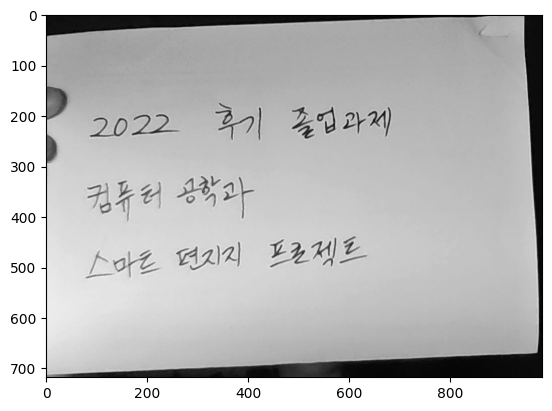

In [36]:
img_cropped = cv2.getRectSubPix( #편지지만큼 잘라냄
        img_gray, 
        patchSize=(int(biggest_rec['w']), int(biggest_rec['h'])), 
        center=(int(biggest_rec['cx']), int(biggest_rec['cy']))
)
plt.imshow(img_cropped, cmap='gray')

정확도를 높이기 위해 선명하게 만들기

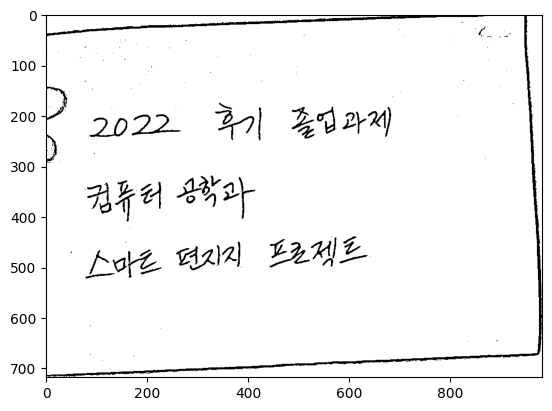

In [37]:
#adaptive threshold
img_thresh = cv2.adaptiveThreshold(
    img_cropped, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY, 
    blockSize=19, 
    C=9
)
plt.imshow(img_thresh,cmap='gray')
plt.imsave('processed.png',img_thresh)

otsu threshold: 96.0
otsu threshold: [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


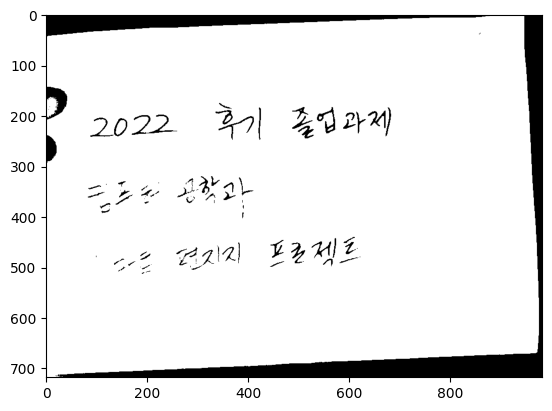

In [38]:
#오츄알고리즘-->기각
t, t_otsu = cv2.threshold(img_cropped, -1, 255,  cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
print('otsu threshold:', t) 
print('otsu threshold:', t_otsu)
plt.imshow(t_otsu,cmap='gray')